In [ ]:
!pip install catboost
!print(catboost.__version__)
!pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.2 MB/s eta 0:00:00
/bin/bash: -c: line 1: syntax error near unexpected token `catboost.__version__'
/bin/bash: -c: line 1: `print(catboost.__version__)'


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ProjectDataSets/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/ProjectDataSets/archive/Supplementary data 3.xlsx
/content/drive/MyDrive/ProjectDataSets/archive/Supplementary data 4.xlsx
/content/drive/MyDrive/ProjectDataSets/archive/SupplementaryData1.xlsx
/content/drive/MyDrive/ProjectDataSets/archive/Supplementary data 5.xlsx
/content/drive/MyDrive/ProjectDataSets/archive/Supplementary data 2.xlsx


In [ ]:
!pip install mrmr_selection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
pd.set_option('display.width', 150)

In [ ]:
biomarker_data = pd.read_excel('/content/drive/MyDrive/ProjectDataSets/archive/SupplementaryData1.xlsx', sheet_name='All Raw Data', dtype=str)
# Remove trailing whitespace from all string columns
biomarker_data = biomarker_data.apply(lambda x: x.str.rstrip() if x.dtype == "object" else x)
validation_data = pd.read_excel('/content/drive/MyDrive/ProjectDataSets/archive/Supplementary data 5.xlsx', sheet_name='All Raw Test Data', dtype=str)
validation_data = validation_data.apply(lambda x: x.str.rstrip() if x.dtype == "object" else x)

In [ ]:
print(biomarker_data.head())

  SUBJECT_ID    AFP     AG Age   ALB ALP ALT AST BASO# BASO%  ...   NEU   PCT   PDW  PHOS  PLT   RBC   RDW  TBIL    TP     UA
0          1   3.58  19.36  47  45.4  56  11  24  0.01   0.3  ...  76.2  0.09  13.4  1.46   74  2.64  13.7   5.5  73.9  396.4
1          2  34.24  23.98  61  39.9  95   9  13  0.02   0.3  ...  76.5   0.3  11.2  1.09  304  4.89  12.7   6.8    72  119.2
2          3   1.50   18.4  39  45.4  77   9  18  0.03   0.6  ...  69.7  0.13  15.2  0.97  112  4.62    12  14.8  77.9  209.2
3          4   2.75   16.6  45  39.2  26  16  17  0.05  0.74  ...  65.5  0.25  17.4  1.25  339  4.01  14.6  10.9  66.1  215.6
4          5   2.36  19.97  45    35  47  21  27  0.01   0.1  ...  59.5  0.28  11.9  0.94  272   4.4  13.4   5.3  66.5    206

[5 rows x 51 columns]


In [ ]:
print(validation_data.head())

  SUBJECT_ID   AFP     AG Age   ALB  ALP ALT AST BASO# BASO%  ...   NEU   PCT   PDW  PHOS  PLT   RBC   RDW  TBIL    TP     UA
0        301  2.26     23  56  35.1  105  12  20  0.04   0.4  ...  75.7  0.62   9.8   1.4  652  4.88  13.2   9.5  73.8  350.3
1        302  3.11     12  72  44.8  128  13  24     0     0  ...  87.8  0.16  11.9  1.41  155  4.41  12.2  21.7  72.2  283.8
2        303  5.02  17.05  57  41.1   89  18  22  0.01   0.3  ...  61.1  0.15  11.3  1.19  144  4.64  12.3    15  71.4  301.3
3        304  1.63  16.26  43  35.2   68   5  13     0     0  ...  84.2  0.26  12.8  0.99  230  3.67  14.1   9.9    59  176.5
4        305  4.76   12.6  65  40.2   81   6  14  0.04   0.5  ...  70.6  0.36  10.7  0.78  375  4.08  12.5   8.2  70.6  308.6

[5 rows x 51 columns]


In [ ]:
print(biomarker_data.shape)

(349, 51)


In [ ]:
print(biomarker_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SUBJECT_ID  349 non-null    object
 1   AFP         327 non-null    object
 2   AG          348 non-null    object
 3   Age         349 non-null    object
 4   ALB         339 non-null    object
 5   ALP         339 non-null    object
 6   ALT         339 non-null    object
 7   AST         339 non-null    object
 8   BASO#       349 non-null    object
 9   BASO%       349 non-null    object
 10  BUN         349 non-null    object
 11  Ca          349 non-null    object
 12  CA125       332 non-null    object
 13  CA19-9      325 non-null    object
 14  CA72-4      109 non-null    object
 15  CEA         327 non-null    object
 16  CL          349 non-null    object
 17  CO2CP       348 non-null    object
 18  CREA        349 non-null    object
 19  TYPE        349 non-null    object
 20  DBIL      

In [ ]:
#List of column names
column_names = []
for column in biomarker_data.columns:
  column_names.append(column)

#Filling the NaN values with a placeholder to avoid errors during any operations
placeholder = 'NaN_placeholder'
for name in column_names:
  biomarker_data[name] = biomarker_data[name].fillna(placeholder)

#Removing any abnormal patterns of data stored usin regular expressions
import re
pattern1 = r'^>[0-9]+(\.[0-9]{2})?$'
for name in column_names:
  # Use str.contains with the regular expression pattern to create a boolean mask
  mask = biomarker_data[name].str.contains(pattern1)
  # Find the indices of the rows that match the pattern
  mask.astype(float)
  indices = biomarker_data.index[mask]
  for index in indices:
    biomarker_data[name][index]=biomarker_data[name][index].split('>')[1]


##Removing any abnormal patterns of data stored usin regular expressions
import re
pattern2 = r'^<([0-9]+\.[0-9]+)$'
for name in column_names:
  # Use str.contains with the regular expression pattern to create a boolean mask
  mask = biomarker_data[name].str.contains(pattern2)
  # Find the indices of the rows that match the pattern
  mask.astype(float)
  indices = biomarker_data.index[mask]
  for index in indices:
    biomarker_data[name][index]=biomarker_data[name][index].split('<')[1]


#Changing the NaN_placeholder values back to NaN to avoid abnormalities in the results
for name in column_names:
  biomarker_data[name] = biomarker_data[name].replace(placeholder, np.nan)
#print(biomarker_data)
#print(biomarker_data['CA19-9'][333])

<ipython-input-13-f890d0654305>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = biomarker_data[name].str.contains(pattern1)
<ipython-input-13-f890d0654305>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = biomarker_data[name].str.contains(pattern1)
<ipython-input-13-f890d0654305>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = biomarker_data[name].str.contains(pattern1)
<ipython-input-13-f890d0654305>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = biomarker_data[name].str.contains(pattern1)
<ipython-input-13-f890d0654305>:16: UserWarning: This pattern is interpreted as a regular expression, and has ma

In [ ]:
#List of column names
validation_column_names = []
for column in validation_data.columns:
  validation_column_names.append(column)

#Filling the NaN values with a placeholder to avoid errors during any operations
placeholder = 'NaN_placeholder'
for name in validation_column_names:
  validation_data[name] = validation_data[name].fillna(placeholder)

#Removing any abnormal patterns of data stored usin regular expressions
import re
pattern1 = r'^>[0-9]+(\.[0-9]{2})?$'
for name in validation_column_names:
  # Use str.contains with the regular expression pattern to create a boolean mask
  mask = validation_data[name].str.contains(pattern1)
  # Find the indices of the rows that match the pattern
  mask.astype(float)
  indices = validation_data.index[mask]
  for index in indices:
    validation_data[name][index]=validation_data[name][index].split('>')[1]


##Removing any abnormal patterns of data stored usin regular expressions
import re
pattern2 = r'^<([0-9]+\.[0-9]+)$'
for name in validation_column_names:
  # Use str.contains with the regular expression pattern to create a boolean mask
  mask = validation_data[name].str.contains(pattern2)
  # Find the indices of the rows that match the pattern
  mask.astype(float)
  indices = validation_data.index[mask]
  for index in indices:
    validation_data[name][index]=validation_data[name][index].split('<')[1]


#Changing the NaN_placeholder values back to NaN to avoid abnormalities in the results
for name in validation_column_names:
  validation_data[name] = validation_data[name].replace(placeholder, np.nan)
#print(biomarker_data)
#print(biomarker_data['CA19-9'][333])

<ipython-input-14-b39c33cdf1c3>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = validation_data[name].str.contains(pattern1)
<ipython-input-14-b39c33cdf1c3>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = validation_data[name].str.contains(pattern1)
<ipython-input-14-b39c33cdf1c3>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = validation_data[name].str.contains(pattern1)
<ipython-input-14-b39c33cdf1c3>:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = validation_data[name].str.contains(pattern1)
<ipython-input-14-b39c33cdf1c3>:16: UserWarning: This pattern is interpreted as a regular expression, and ha

In [ ]:
# Convert object columns to float columns
for col in biomarker_data.drop('TYPE', axis=1).select_dtypes(include=['object']).columns:
    biomarker_data[col] = biomarker_data[col].astype('float')
for col in validation_data.drop('TYPE', axis=1).select_dtypes(include=['object']).columns:
    validation_data[col] = validation_data[col].astype('float')

# Convert target column to integer
biomarker_data['TYPE'] = biomarker_data['TYPE'].astype('int64')
validation_data['TYPE'] = validation_data['TYPE'].astype('int64')


In [ ]:
# Computing the ratio of missing data in each column
missing_ratio = biomarker_data.isnull().mean()

# Displaying the ratio of missing data in each column
print(missing_ratio)

SUBJECT_ID    0.000000
AFP           0.063037
AG            0.002865
Age           0.000000
ALB           0.028653
ALP           0.028653
ALT           0.028653
AST           0.028653
BASO#         0.000000
BASO%         0.000000
BUN           0.000000
Ca            0.000000
CA125         0.048711
CA19-9        0.068768
CA72-4        0.687679
CEA           0.063037
CL            0.000000
CO2CP         0.002865
CREA          0.000000
TYPE          0.000000
DBIL          0.028653
EO#           0.000000
EO%           0.000000
GGT           0.028653
GLO           0.028653
GLU.          0.000000
HCT           0.000000
HE4           0.057307
HGB           0.000000
IBIL          0.028653
K             0.000000
LYM#          0.000000
LYM%          0.000000
MCH           0.000000
MCV           0.000000
Menopause     0.000000
Mg            0.000000
MONO#         0.000000
MONO%         0.000000
MPV           0.005731
Na            0.000000
NEU           0.260745
PCT           0.005731
PDW        

In [ ]:
# split data into features (X) and target (y)
biomarker_X_train = biomarker_data.drop('TYPE', axis=1)
biomarker_y_train = biomarker_data['TYPE']
validation_X = validation_data.drop('TYPE', axis=1)
validation_Y = validation_data['TYPE']

In [ ]:
# select top 18 features using MRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=biomarker_X_train, y=biomarker_y_train, K=18)
val_selected_features = selected_features

100%|██████████| 18/18 [00:00<00:00, 27.15it/s]


In [ ]:
selected_features

['SUBJECT_ID',
 'PCT',
 'LYM#',
 'Age',
 'Menopause',
 'CA125',
 'ALB',
 'NEU',
 'HE4',
 'CEA',
 'GLO',
 'AST',
 'LYM%',
 'ALP',
 'HGB',
 'PLT',
 'TBIL',
 'CA19-9']

In [ ]:
# Visualizing the correlation between the features in the training data
selected_cols = selected_features + ['TYPE']

# Selecting the row or column corresponding to the target column
target_corr = biomarker_data[selected_cols].corr()['TYPE']

# Displaying the correlation values of each feature with the target column in descending order
print("Correlation of selected features with target column \n")
print(target_corr)

Correlation of selected features with target column 

SUBJECT_ID    0.678238
PCT          -0.243649
LYM#          0.256494
Age          -0.514098
Menopause    -0.455770
CA125        -0.404103
ALB           0.380158
NEU          -0.437075
HE4          -0.385290
CEA          -0.182879
GLO          -0.198387
AST          -0.217904
LYM%          0.315035
ALP          -0.215681
HGB           0.197863
PLT          -0.270182
TBIL          0.199730
CA19-9       -0.182289
TYPE          1.000000
Name: TYPE, dtype: float64


In [ ]:
# Selecting the row or column corresponding to the target column
target_corr = biomarker_data[selected_cols].corr()['TYPE']
target_corr = np.sqrt(target_corr ** 2) # find the magnitude of each correlation

# Displaying the correlation values of each feature with the target column in descending order
print(target_corr.sort_values(ascending=False))

TYPE          1.000000
SUBJECT_ID    0.678238
Age           0.514098
Menopause     0.455770
NEU           0.437075
CA125         0.404103
HE4           0.385290
ALB           0.380158
LYM%          0.315035
PLT           0.270182
LYM#          0.256494
PCT           0.243649
AST           0.217904
ALP           0.215681
TBIL          0.199730
GLO           0.198387
HGB           0.197863
CEA           0.182879
CA19-9        0.182289
Name: TYPE, dtype: float64


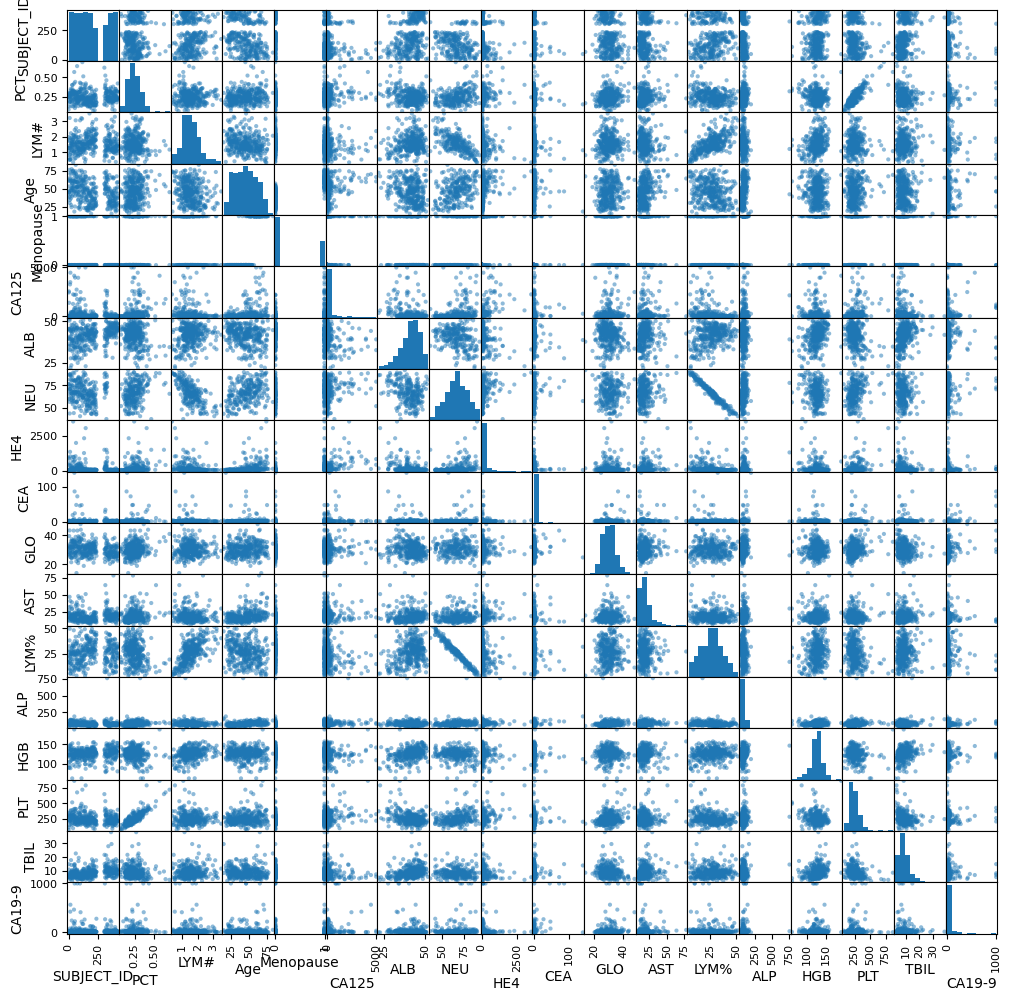

In [ ]:
# Create scatter plot matrix
pd.plotting.scatter_matrix(biomarker_data[selected_features], figsize=(12, 12))
plt.show()

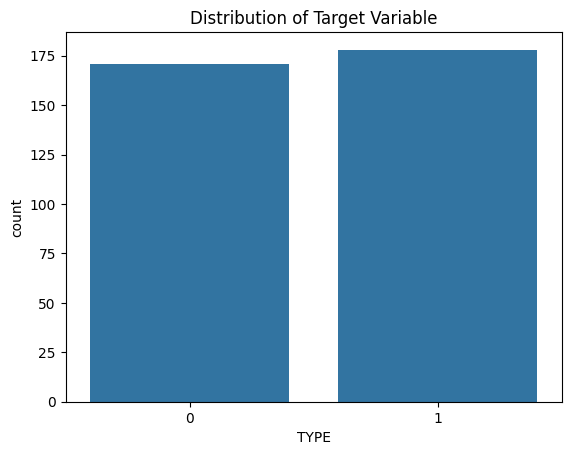

In [ ]:
# Visualizing the distribution of the target variable in the training data
target_variable = biomarker_data['TYPE']
sns.countplot(x=target_variable, data=biomarker_data)
plt.title('Distribution of Target Variable')
plt.show()

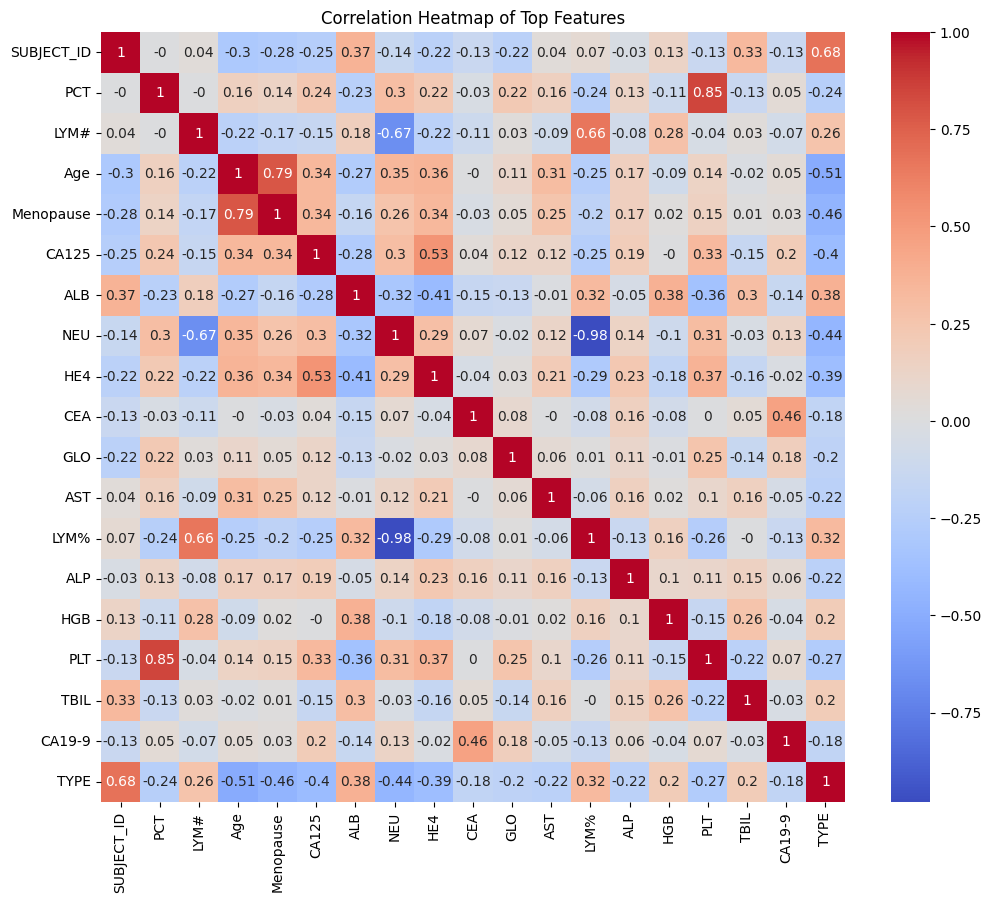

In [ ]:
# Create a correlation matrix
corr_matrix = np.around(biomarker_data[selected_cols].corr(), 2)

# Plot the heatmap using seaborn
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Top Features')
plt.rcParams['figure.dpi']=600
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

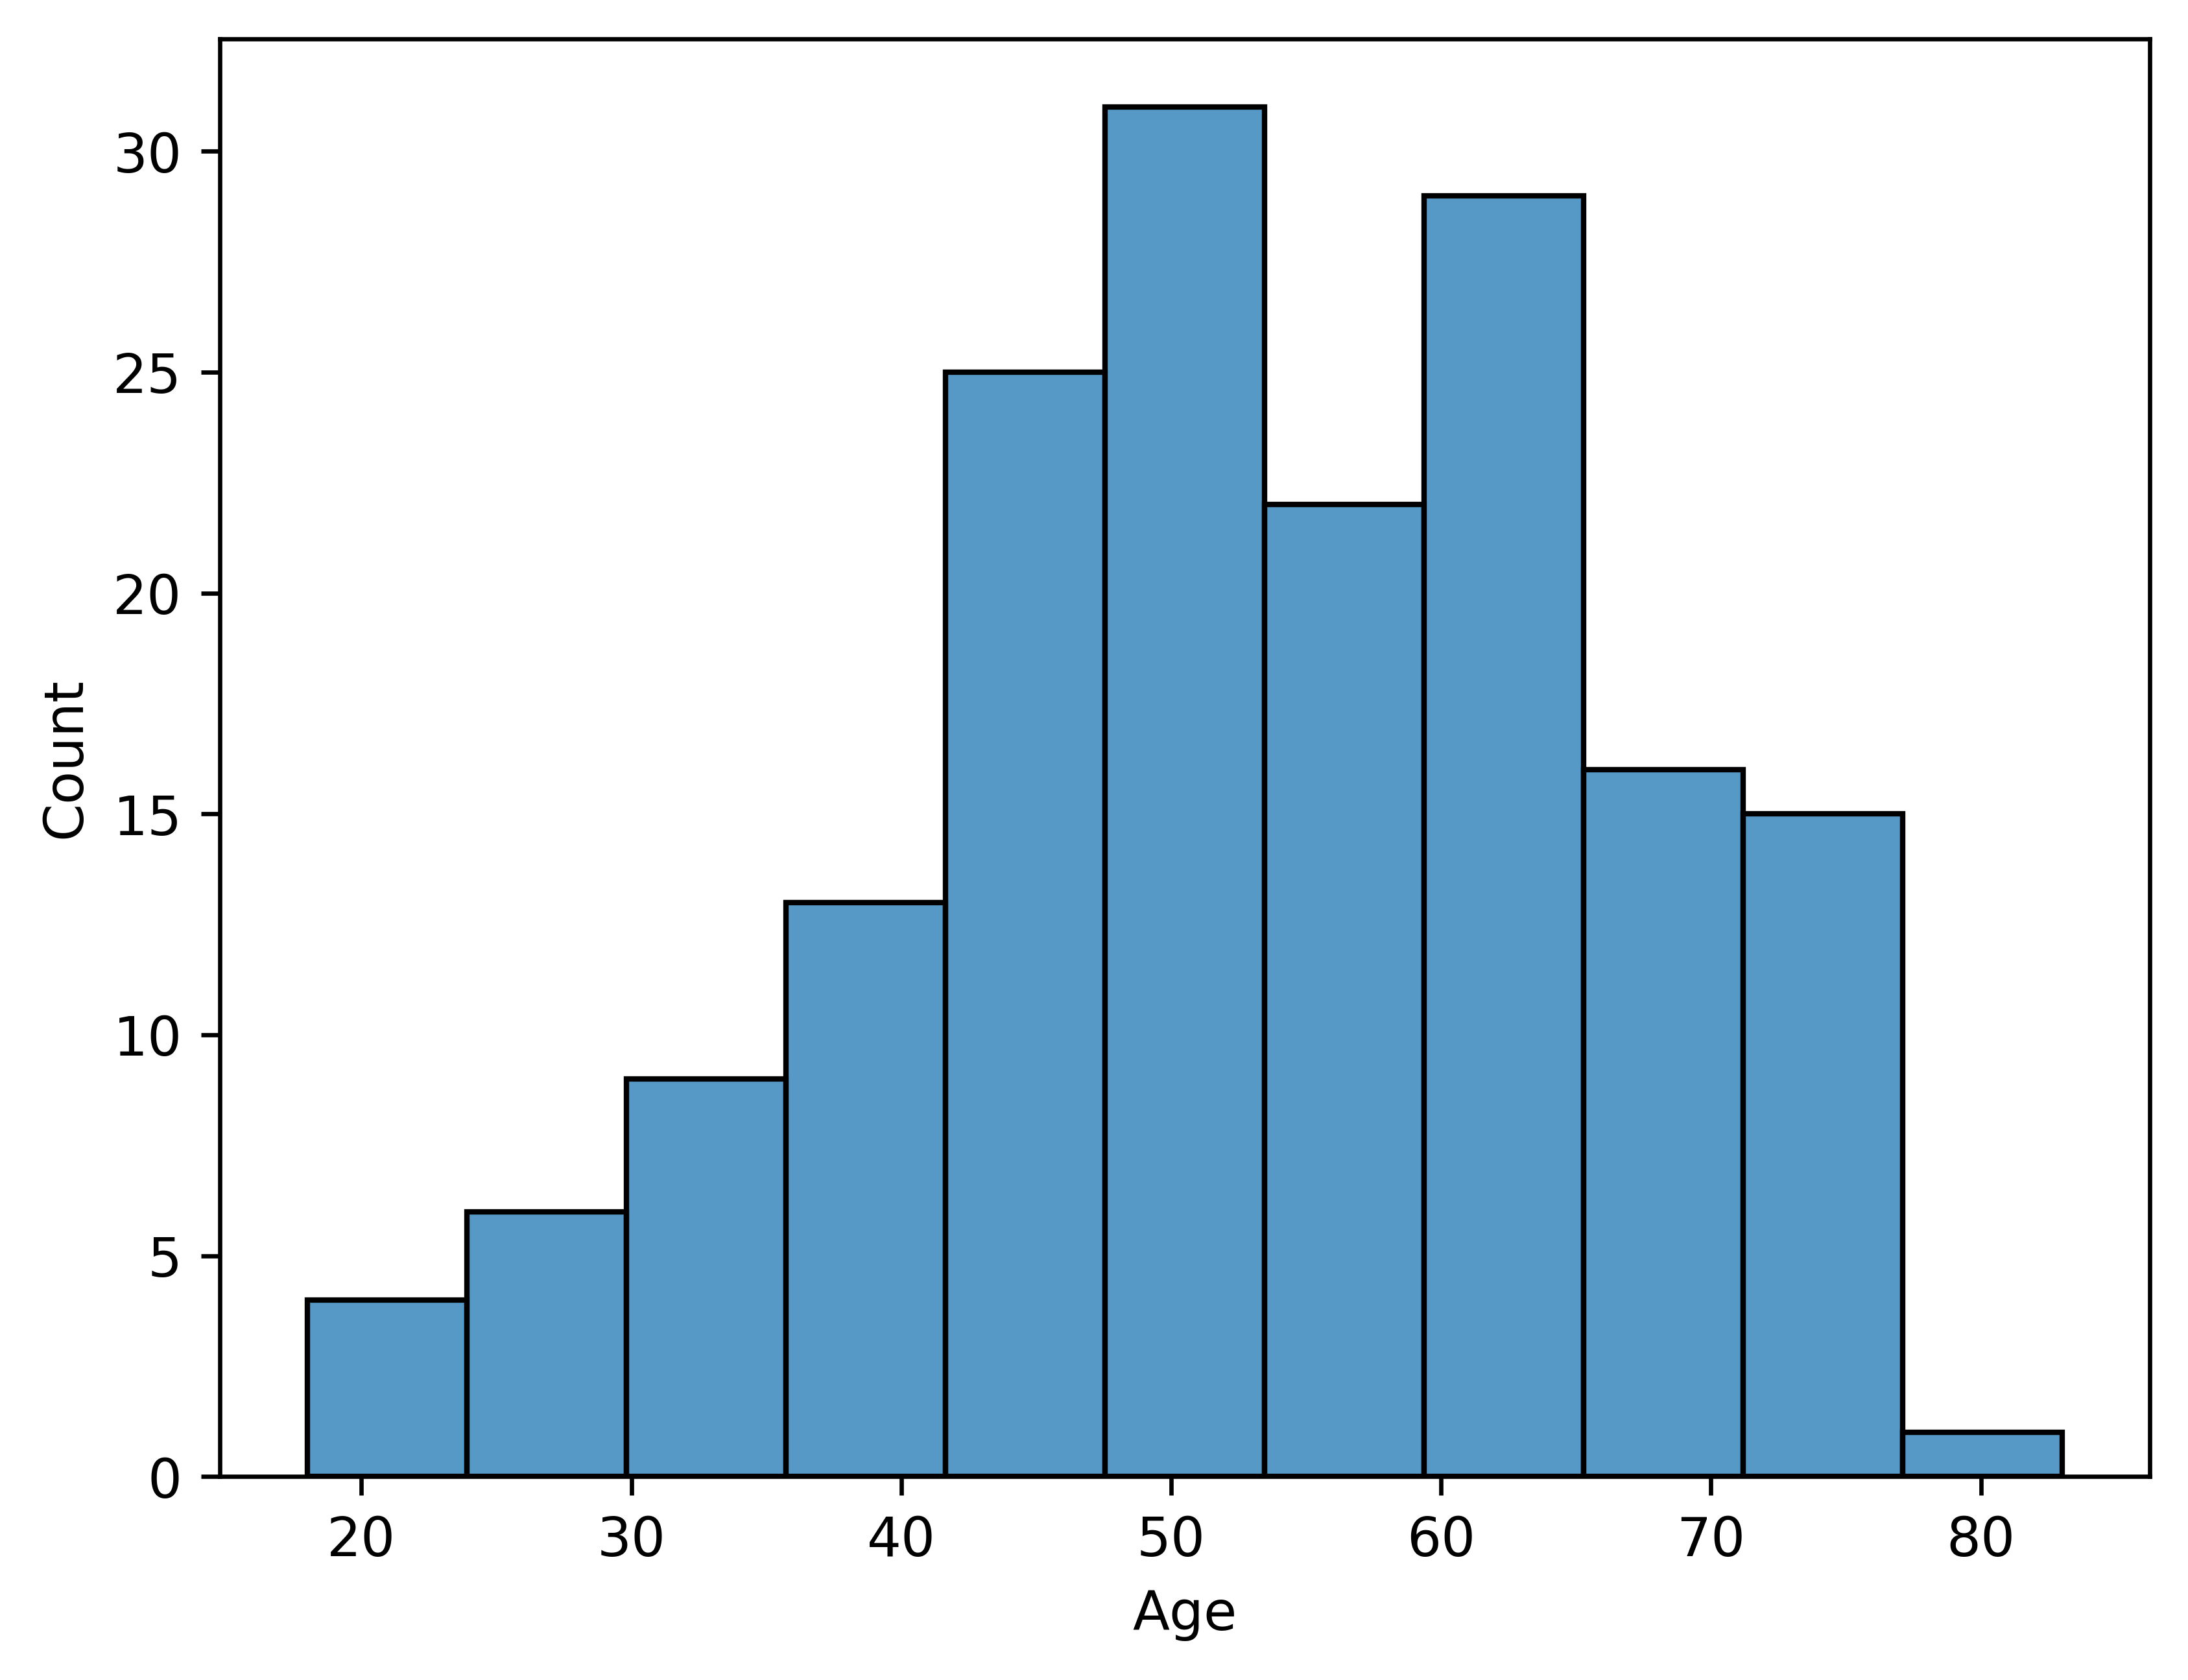

In [ ]:
# Filter the data to only include positive values of the "TYPE" target column
positive_data = biomarker_data[biomarker_data['TYPE'] == 0]

# Create histogram using Seaborn
sns.histplot(data=positive_data, x="Age")

In [ ]:
X = biomarker_X_train[selected_features].values
y = biomarker_y_train.values
X_val = validation_X[selected_features].values
Y_val = validation_Y.values


In [ ]:
# Handle missing data using KNN Imputation
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X_val_imputed = imputer.fit_transform(X_val)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create the CatBoost model
# Define evaluation metric (accuracy)
eval_metric = "Accuracy"
# Train the CatBoost model with evaluation set
model = catboost.CatBoostClassifier(iterations=500,  # Number of iterations with no improvement to wait before stopping
                           use_best_model=True,  # Use the best model found during training
                           l2_leaf_reg=3,
                           random_seed=42,
                           eval_metric=eval_metric)
model.fit(X_train, y_train, eval_set=(X_val_imputed, Y_val))

0:	learn: 0.9731801	test: 0.9210526	best: 0.9210526 (0)	total: 52.4ms	remaining: 26.1s
1:	learn: 0.9846743	test: 0.9824561	best: 0.9824561 (1)	total: 55.4ms	remaining: 13.8s
2:	learn: 0.9846743	test: 0.9736842	best: 0.9824561 (1)	total: 62.7ms	remaining: 10.4s
3:	learn: 0.9923372	test: 0.9473684	best: 0.9824561 (1)	total: 68.4ms	remaining: 8.49s
4:	learn: 0.9923372	test: 0.9473684	best: 0.9824561 (1)	total: 75ms	remaining: 7.43s
5:	learn: 0.9923372	test: 0.9473684	best: 0.9824561 (1)	total: 86.3ms	remaining: 7.11s
6:	learn: 0.9923372	test: 0.9473684	best: 0.9824561 (1)	total: 94.3ms	remaining: 6.64s
7:	learn: 0.9923372	test: 0.9473684	best: 0.9824561 (1)	total: 104ms	remaining: 6.4s
8:	learn: 0.9923372	test: 0.9561404	best: 0.9824561 (1)	total: 111ms	remaining: 6.03s
9:	learn: 0.9923372	test: 0.9561404	best: 0.9824561 (1)	total: 120ms	remaining: 5.89s
10:	learn: 0.9923372	test: 0.9561404	best: 0.9824561 (1)	total: 127ms	remaining: 5.63s
11:	learn: 0.9923372	test: 0.9561404	best: 0.9824

In [ ]:
# Train the model
#model.fit(X_train, y_train, eval_set=(X_val, Y_val))

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
# Evaluate the model
training_accuracy = model.score(X_train, y_train)
catboost_accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
print("Accuracy:", catboost_accuracy)
print("Precision:", precision)
print(classification_report(y_test, y_pred))

Accuracy: 98.86363636363636
Precision: 100.0
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.98      0.99        43

    accuracy                           0.99        88
   macro avg       0.99      0.99      0.99        88
weighted avg       0.99      0.99      0.99        88



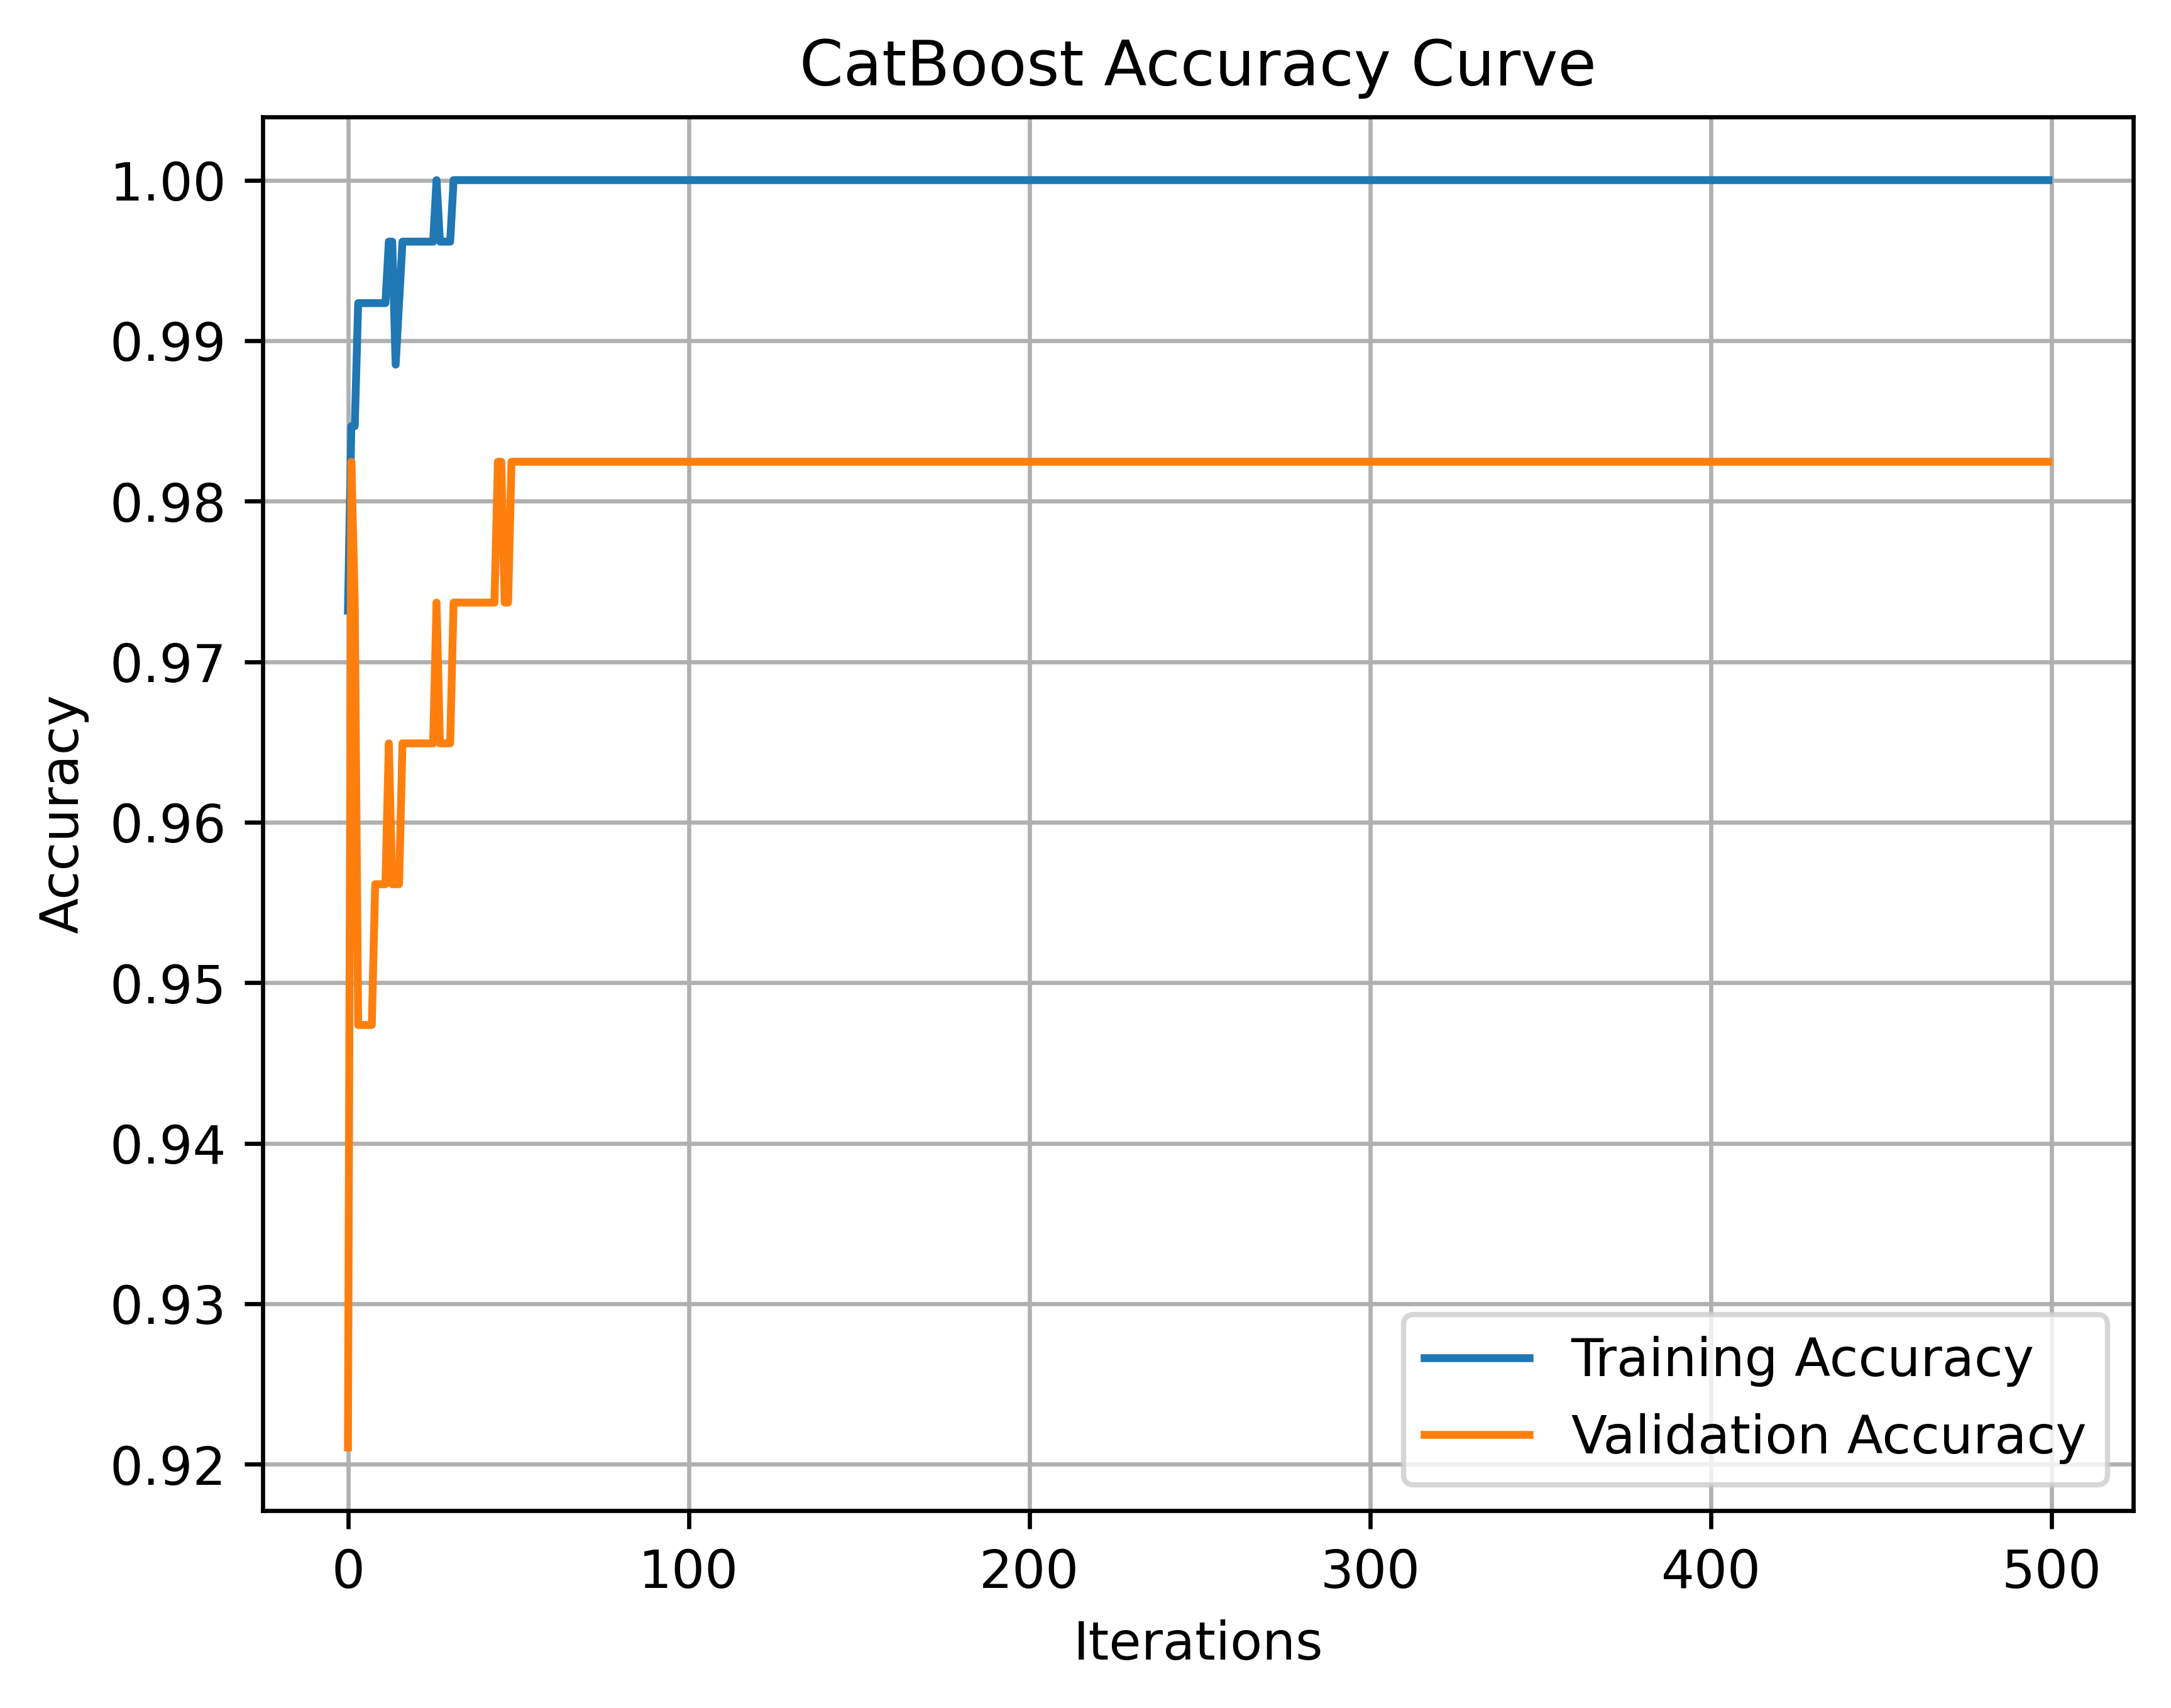

In [ ]:
train_scores = model.get_evals_result()['learn']['Accuracy']
val_scores = model.get_evals_result()['validation']['Accuracy']
iterations = range(1, len(train_scores) + 1)
#print(train_scores)
#print(val_scores)
# Plot accuracy curve
plt.plot(train_scores, label="Training Accuracy")
plt.plot(val_scores, label="Validation Accuracy")
plt.title("CatBoost Accuracy Curve")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

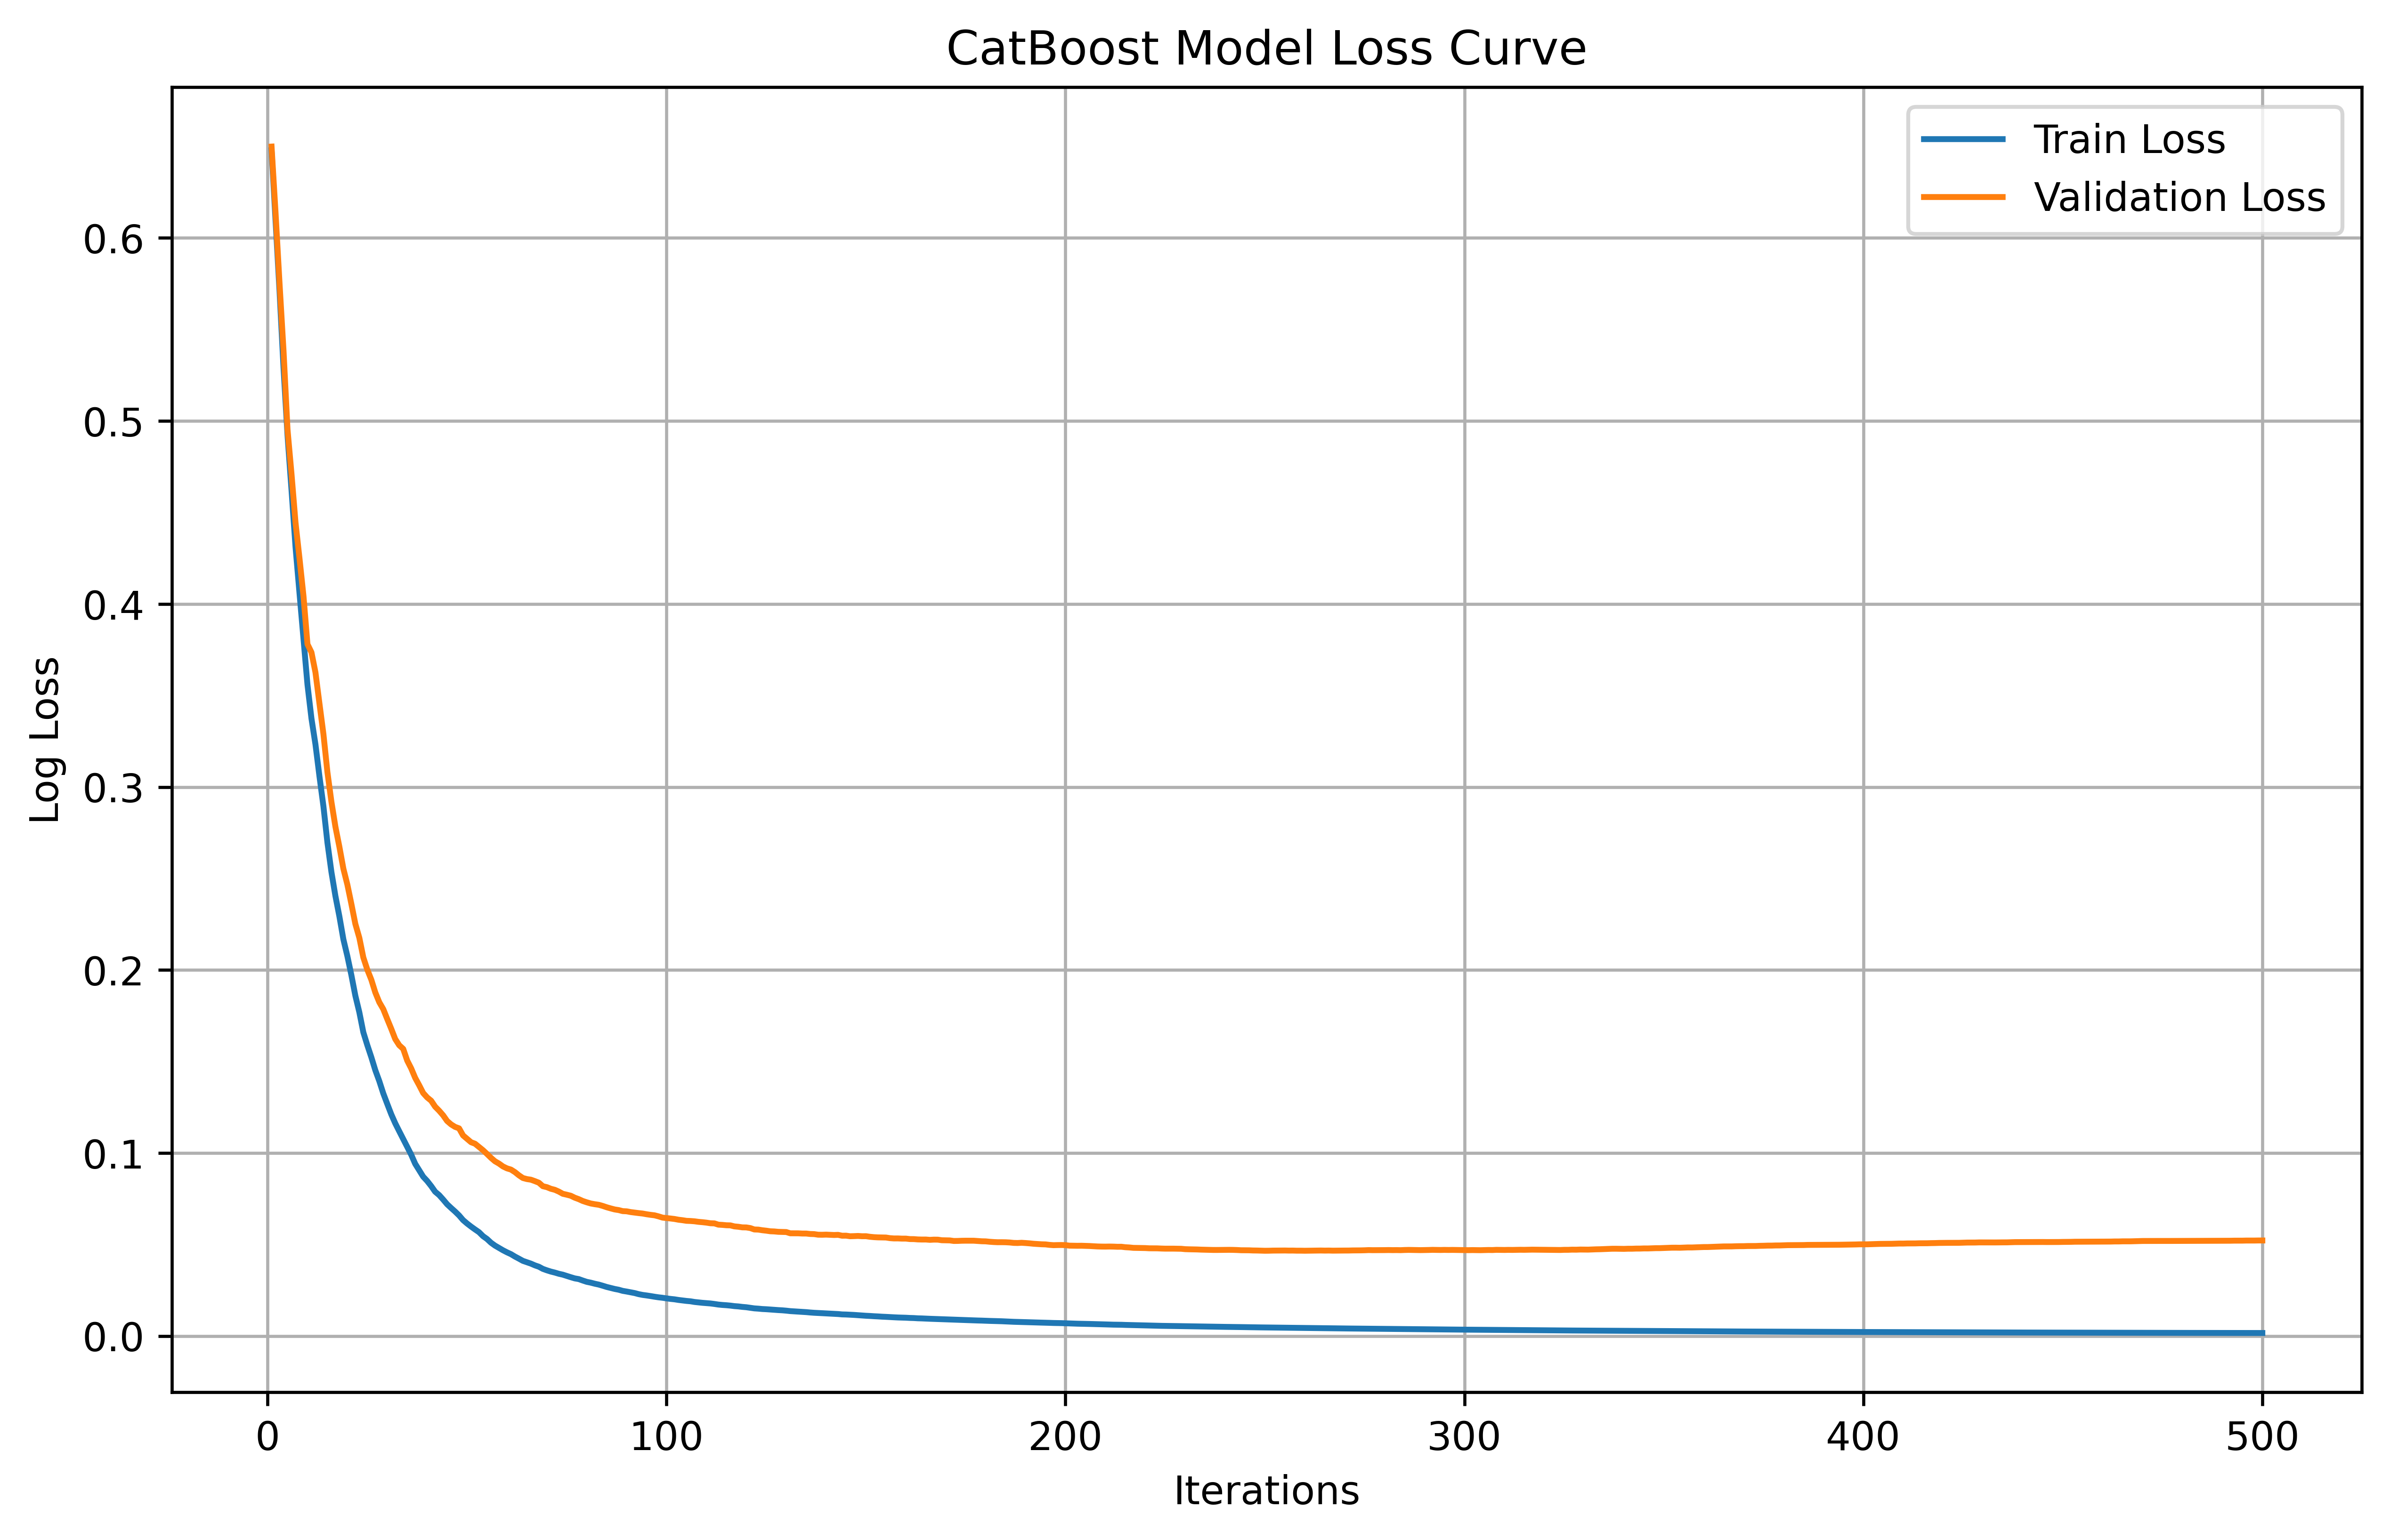

In [ ]:
train_losses = model.get_evals_result()['learn']['Logloss']
val_losses = model.get_evals_result()['validation']['Logloss']
# Plot the loss curve
iterations = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_losses, label='Train Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('CatBoost Model Loss Curve')
plt.legend()
plt.grid(True)
plt.show()